In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import numpy as np
from scipy.fft import fft2
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt
from google.colab import files, drive
import os
import io
import random
from sklearn.model_selection import train_test_split

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_deepfake_classifier(fda_feature_dim=12544):
    """
    Classify FDA features as real (1) or fake (0).
    """
    # Define input layer
    inputs = tf.keras.Input(shape=(fda_feature_dim,))

    # First dense layer with ReLU activation
    x = layers.Dense(512, activation='relu')(inputs)

    # Dropout layer
    x = layers.Dropout(0.5)(x)

    # Output dense layer with sigmoid activation
    outputs = layers.Dense(1, activation='sigmoid')(x)

    # Create model
    model = models.Model(inputs=inputs, outputs=outputs, name='DeepfakeClassifier')

    return model

In [ ]:
import tensorflow as tf
from PIL import Image
import io
import numpy as np

def preprocess_image(image_data, size=(224, 224), is_path=True, augment=True):
    """
    Load and preprocess an image for FDA with optional augmentation.
    Args:
        image_data (str or bytes): Image path (training) or bytes (testing).
        size (tuple): Target size for resizing (height, width).
        is_path (bool): True if image_data is a file path.
        augment (bool): Apply data augmentation if True.
    Returns:
        tf.Tensor: Preprocessed image tensor [1, H, W, C].
    """
    try:
        # Load image
        if is_path:
            image = Image.open(image_data).convert('RGB')
        else:
            image = Image.open(io.BytesIO(image_data)).convert('RGB')

        # Convert PIL image to numpy array
        image_np = np.array(image, dtype=np.float32)

        # Resize image
        image_tf = tf.image.resize(image_np, size, method='bilinear')

        # Apply augmentations if enabled
        if augment:
            # Random horizontal flip
            image_tf = tf.image.random_flip_left_right(image_tf)

            # Random rotation (approximating 10 degrees)
            angle = tf.random.uniform((), minval=-10, maxval=10) * np.pi / 180
            image_tf = tf.keras.preprocessing.image.apply_affine_transform(
                image_tf.numpy(),
                theta=angle * 180 / np.pi,  # Convert radians to degrees
                fill_mode='nearest'
            )
            image_tf = tf.convert_to_tensor(image_tf)

            # Color jitter: brightness and contrast
            image_tf = tf.image.random_brightness(image_tf, max_delta=0.2)
            image_tf = tf.image.random_contrast(image_tf, lower=0.8, upper=1.2)

        # Normalize image (equivalent to PyTorch's mean and std)
        mean = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
        std = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)
        image_tf = (image_tf / 255.0 - mean) / std

        # Add batch dimension
        image_tf = tf.expand_dims(image_tf, axis=0)

        return image_tf
    except Exception as e:
        print(f"Error preprocessing image: {str(e)}")
        return None

In [ ]:
import tensorflow as tf
import numpy as np
from scipy.fft import fft2

def frequency_domain_analysis(image_tensor, high_freq_ratio=0.5):
    """
    Perform FDA to extract frequency features.
    Args:
        image_tensor (tf.Tensor): Input image tensor [1, H, W, C].
        high_freq_ratio (float): Ratio of high-frequency components to retain.
    Returns:
        tf.Tensor: Flattened frequency feature vector.
        np.ndarray: Magnitude spectrum for visualization.
    """
    try:
        # Convert to grayscale by averaging across channels (axis=3 for channels-last)
        image_gray = tf.reduce_mean(image_tensor, axis=3, keepdims=True)

        # Remove batch and channel dimensions for FFT (shape: [H, W])
        image_np = image_gray[0, :, :, 0].numpy()

        # Perform 2D FFT and compute magnitude spectrum
        fft_result = fft2(image_np)
        magnitude_spectrum = np.abs(fft_result)
        magnitude_spectrum = np.fft.fftshift(magnitude_spectrum)

        # Extract high-frequency region
        h, w = magnitude_spectrum.shape
        center_h, center_w = h // 2, w // 2
        high_freq_size = int(min(h, w) * high_freq_ratio / 2)

        high_freq_region = magnitude_spectrum[
            center_h - high_freq_size:center_h + high_freq_size,
            center_w - high_freq_size:center_w + high_freq_size
        ]

        # Flatten and normalize features
        features = high_freq_region.flatten()
        features = (features - features.mean()) / (features.std() + 1e-8)

        # Convert to TensorFlow tensor
        feature_tensor = tf.convert_to_tensor(features, dtype=tf.float32)

        return feature_tensor, magnitude_spectrum
    except Exception as e:
        print(f"Error in FDA: {str(e)}")
        return None, None

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

def visualize_magnitude_spectrum(image_tensor, magnitude_spectrum, save_path='magnitude_spectrum.png'):
    """
    Visualize the original image and magnitude spectrum.
    Args:
        image_tensor (tf.Tensor): Input image tensor [1, H, W, C].
        magnitude_spectrum (np.ndarray): Magnitude spectrum from FFT.
        save_path (str): Path to save the visualization.
    """
    try:
        plt.figure(figsize=(10, 5))

        # Original image
        plt.subplot(1, 2, 1)
        image_np = image_tensor[0].numpy()  # Shape: [H, W, C]
        image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min() + 1e-8)
        plt.imshow(image_np)
        plt.title('Original Image')
        plt.axis('off')

        # Magnitude spectrum
        plt.subplot(1, 2, 2)
        plt.imshow(np.log1p(magnitude_spectrum), cmap='viridis')
        plt.title('Magnitude Spectrum (Log Scale)')
        plt.axis('off')

        plt.savefig(save_path)
        plt.show()
        files.download(save_path)
    except Exception as e:
        print(f"Error in visualization: {str(e)}")

In [ ]:

# Assume build_deepfake_classifier, preprocess_image, frequency_domain_analysis, visualize_magnitude_spectrum are defined

def train_fda(image_folder, num_epochs=15, val_split=0.2):
    """
    Process images from a folder and train the classifier with validation.
    Args:
        image_folder (str): Path to folder with 'real' and 'fake' subfolders.
        num_epochs (int): Number of training epochs.
        val_split (float): Fraction of data for validation.
    Returns:
        tf.keras.Model: Trained classifier model.
    """
    print("=== Starting Training ===")

    model = build_deepfake_classifier(fda_feature_dim=12544)
    model.compile(optimizer=Adam(learning_rate=0.00005),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    valid_extensions = ['.jpg', '.jpeg', '.png']
    feature_list = []
    visualized = {'real': False, 'fake': False}

    for subfolder in ['real', 'fake']:
        subfolder_path = os.path.join(image_folder, subfolder)
        if not os.path.exists(subfolder_path):
            print(f"ERROR: Subfolder '{subfolder_path}' not found. Please create it and add images.")
            return None

    for label, subfolder in [(1, 'real'), (0, 'fake')]:
        subfolder_path = os.path.join(image_folder, subfolder)
        image_files = [f for f in os.listdir(subfolder_path) if any(f.lower().endswith(ext) for ext in valid_extensions)]
        if not image_files:
            print(f"WARNING: No valid images found in '{subfolder_path}'. Please add .jpg, .jpeg, or .png files.")
            continue

        for image_name in image_files:
            image_path = os.path.join(subfolder_path, image_name)
            try:
                image_tensor = preprocess_image(image_path, is_path=True, augment=True)
                if image_tensor is None:
                    continue
                fda_features, magnitude_spectrum = frequency_domain_analysis(image_tensor)
                if fda_features is None:
                    continue

                # Visualize the first image per class
                if not visualized[subfolder]:
                    viz_path = os.path.join(image_folder, f"{subfolder}_spectrum.png")
                    visualize_magnitude_spectrum(image_tensor, magnitude_spectrum, save_path=viz_path)
                    visualized[subfolder] = True

                feature_list.append((fda_features.numpy(), label, image_path))
                print(f"Processed: {image_name}, Label: {'Real' if label == 1 else 'Fake'}, Feature shape: {fda_features.shape}")
            except Exception as e:
                print(f"Error processing {image_name}: {str(e)}")

    if not feature_list:
        print("ERROR: No images processed. Training cannot proceed. Please check your dataset.")
        return None

    real_features = [(f, l, p) for f, l, p in feature_list if l == 1]
    fake_features = [(f, l, p) for f, l, p in feature_list if l == 0]
    min_count = min(len(real_features), len(fake_features))
    if min_count == 0:
        print("ERROR: One class has no images. Please add images to both 'real' and 'fake' folders.")
        return None

    balanced_features = random.sample(real_features, min_count) + random.sample(fake_features, min_count)
    random.shuffle(balanced_features)
    print(f"Balanced dataset: {len(balanced_features)} images (Real: {min_count}, Fake: {min_count})")

    X = np.array([f for f, _, _ in balanced_features])
    y = np.array([l for _, l, _ in balanced_features], dtype=np.float32)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_split, random_state=42)
    print(f"Training set: {len(X_train)} images, Validation set: {len(X_val)} images")

    history = model.fit(
        X_train, y_train,
        epochs=num_epochs,
        validation_data=(X_val, y_val),
        batch_size=1,
        verbose=1
    )

    for epoch in range(num_epochs):
        train_loss = history.history['loss'][epoch]
        train_acc = history.history['accuracy'][epoch]
        val_loss = history.history['val_loss'][epoch]
        val_acc = history.history['val_accuracy'][epoch]
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.6f}, Val Acc: {val_acc:.4f}")

    model_path = os.path.join(image_folder, 'deepfake_classifier.h5')
    model.save(model_path)
    print(f"Model saved to {model_path}")

    print(f"=== Training Completed. Processed {len(balanced_features)} images ===")
    return model

In [ ]:
import os
import numpy as np
import tensorflow as tf
try:
    from google.colab import files
except ImportError:
    files = None  # Fallback for non-Colab environments

# Assume build_deepfake_classifier, preprocess_image, frequency_domain_analysis, visualize_magnitude_spectrum are defined

def test_fda(model, model_path=None):
    """
    Test deepfake detection on an uploaded image and predict 'real' (1) or 'fake' (0).
    Args:
        model (tf.keras.Model): Deepfake classifier model.
        model_path (str): Path to load a pre-trained model (optional).
    Returns:
        np.ndarray: Frequency feature vector.
        float: Prediction probability.
    """
    # Load pre-trained model if provided
    if model_path and os.path.exists(model_path):
        model = tf.keras.models.load_model(model_path)
        print(f"Loaded pre-trained model from {model_path}")

    print("=== Starting Testing ===")
    print("Please upload an image file (e.g., .jpg, .png):")

    # Handle image upload
    if files is not None:
        uploaded = files.upload()
    else:
        print("File upload not supported outside Colab. Please provide image path or bytes.")
        return None, None

    if not uploaded:
        print("No file uploaded.")
        return None, None

    image_name = list(uploaded.keys())[0]
    image_data = uploaded[image_name]

    try:
        image_tensor = preprocess_image(image_data, is_path=False, augment=False)
        if image_tensor is None:
            return None, None
        fda_features, magnitude_spectrum = frequency_domain_analysis(image_tensor)
        if fda_features is None:
            return None, None

        # Predict with model
        pred_prob = model.predict(fda_features[np.newaxis, :], verbose=0)[0][0]
        pred_label = 'Real' if pred_prob >= 0.5 else 'Fake'
        pred_value = 1 if pred_prob >= 0.5 else 0

        # Visualize
        visualize_magnitude_spectrum(image_tensor, magnitude_spectrum)

        print(f"Test image: {image_name}")
        print(f"Frequency features shape: {fda_features.shape}")
        print(f"The image is predicted to be: {pred_label} (Value: {pred_value}, Probability: {pred_prob:.4f})")

        print("=== Testing Completed ===")
        return fda_features.numpy(), pred_prob

    except Exception as e:
        print(f"Error processing test image: {str(e)}")
        return None, None

In [ ]:
if __name__ == "__main__":
    import os
    import tensorflow as tf
    try:
        from google.colab import drive
        # Mount Google Drive
        drive.mount('/content/drive')
    except ImportError:
        print("Not in Colab environment. Ensure image folder path is accessible.")

    # Specify your training image folder
    train_image_folder = '/content/drive/MyDrive/MORE DATASETS'

    # Run training
    model = train_fda(train_image_folder, num_epochs=15)
    if model is None:
        print("Training failed. Creating default model for testing.")
        model = build_deepfake_classifier(fda_feature_dim=12544)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== Starting Training ===


KeyboardInterrupt: 

Loaded pre-trained model from /content/drive/MyDrive/MODELS/4000-Modelaa/deepfake_classifier.h5
=== Starting Testing ===
Please upload an image file (e.g., .jpg, .png):


Saving df01171.jpg to df01171.jpg


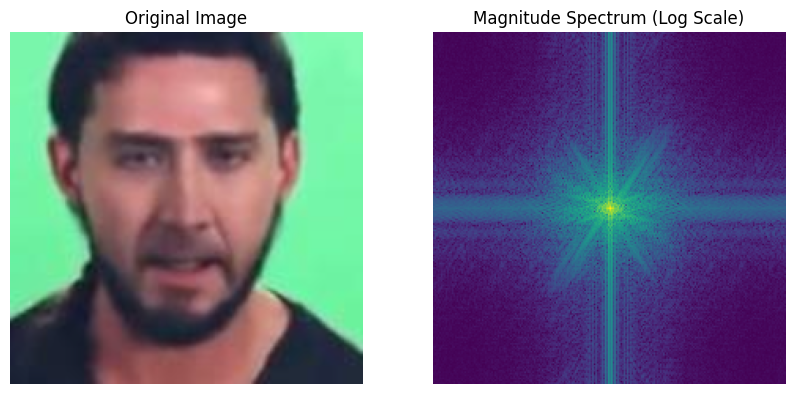

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Test image: df01171.jpg
Frequency features shape: (12544,)
The image is predicted to be: Fake (Value: 0, Probability: 0.0309)
=== Testing Completed ===
Testing successful. Feature shape: (12544,), Prediction probability: 0.0309


In [ ]:
# Define model path and run testing
# model_path = os.path.join(train_image_folder, 'deepfake_classifier.h5')
model_path = '/content/drive/MyDrive/MODELS/4000-Modelaa/deepfake_classifier.h5'
test_features, pred_prob = test_fda(None, model_path=model_path)
if test_features is not None and pred_prob is not None:
      print(f"Testing successful. Feature shape: {test_features.shape}, Prediction probability: {pred_prob:.4f}")
else:
      print("Testing failed. Check image upload or processing.")